In [1]:
import os
import itertools
import math

from collections import namedtuple

# Additional Modules

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64
from skimage.measure import compare_psnr, compare_ssim, compare_mse
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv
from tqdm import tqdm
from skimage.util import crop
from skimage.transform import rotate


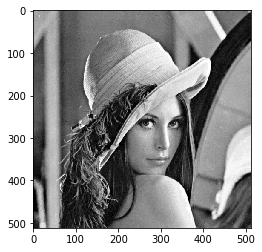

In [2]:
lenna_rgb_512x512 = io.imread('test_files/lenna.bmp')
lenna_rgb_256x256 = resize(lenna_rgb_512x512, (256, 256))
lenna_gray_512x512 = np.rint(rgb2gray(lenna_rgb_512x512) * 255).astype('uint8')
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype('uint8')
type(lenna_rgb_512x512)
plt.imshow(lenna_gray_512x512, cmap = "gray")

253.23921568627446


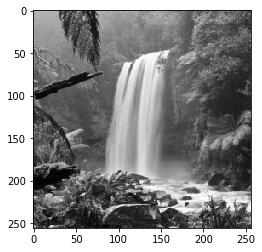

In [3]:
waterfall = io.imread("test_files/fractal_compr.jpg")
waterfall_gray_512x512 = np.rint(rgb2gray(waterfall) * 255).astype('uint8')
waterfall_gray_256x256 = 255*resize(waterfall_gray_512x512, (256, 256), clip = True)
new = 256*resize(waterfall_gray_512x512, (256, 256))
print(np.max(new))
plt.imshow(new, cmap = 'gray')

In [4]:
BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'di', 'tr'])
MyBlockTransform = namedtuple('MyBlockTransform', ['x', 'y', 'shift', 'num', 'scale'])
FractalCompressionParams = namedtuple(
    'FractalCompressionParams', [
        'height',
        'width',
        'is_colored',
        'block_size',
        'spatial_scale',
        'intensity_scale',
        'stride'
    ]
)
Params = namedtuple('Params', ['block_size', 'stride', 'spatial_scale', 'intensity_scale'])

In [5]:
def derive_num_bits(length, stride):
    print(np.ceil(np.log2(length / stride)).astype(int))
    return np.ceil(np.log2(length / stride)).astype(int)

def is_colored(image):
    if len(image.shape) == 2:
        return False
    elif len(image.shape) == 3 and image.shape[-1] == 3:
        return True
    else:
        message = 'Invalid shape of the image: `{}`'
        raise ValueError(message.format(image.shape))
        
def transform_block(block, num, spacial_scale, intensity_scale = 0.9):
    for k in range(0, num):
        if k % 4 == 0:
            block = np.array([block[block.shape[0] - r - 1] for r in range(0, block.shape[0])])
        else:
            block = np.rot90(block)
    return spacial_scale + intensity_scale*block

In [6]:
def transform_block(block, num, spacial_scale, intensity_scale = 0.9):
    for k in range(0, num):
        if k % 4 == 0:
            block = np.array([block[block.shape[0] - r - 1] for r in range(0, block.shape[0])])
        else:
            block = np.rot90(block)
    return spacial_scale + intensity_scale*block

def my_find_block_transform(image, resized_image, x, y, block_size, stride, intensity_scale = 0.9):
    n_iters = int((resized_image.shape[0] - block_size)/stride) + 1
    mymin = block_size * block_size * 256 * 256.0
    my_block = np.array(image[x : x + block_size, y : y + block_size], dtype = float)
    res = MyBlockTransform(0, 0, 0, 0, 0)
    #if block_size % stride == 0:
    #    n_iters += 1
    for i in range(0, n_iters):
        for j in range (0, n_iters):
            current_block = np.array(resized_image[i * stride : i * stride + block_size, j * stride : j * stride + block_size], dtype = float)
            for k in range(0, 8):
                q = np.sum(my_block - intensity_scale*current_block)/(my_block.shape[0] ** 2)
                if np.sum((my_block - q - intensity_scale*current_block)**2) < mymin:
                    mymin = np.sum((my_block - q - intensity_scale * current_block)**2)
                    res = MyBlockTransform(i, j, 0.9, k, q)
                    #print(res)
                if k % 4 == 0:
                    current_block = np.rot90(current_block.T)
                    #current_block = np.array([current_block[current_block.shape[0] - r - 1] for r in range(0, current_block.shape[0])])
                else:
                    current_block = np.rot90(current_block)
    return res

def my_compressor (image, block_size=8, stride=1,
                 spatial_scale=0.5, intensity_scale=0.9):
    resized_image = lenna_gray_256x256
    transformations = []
    for i in range(0, int(image.shape[0]/block_size)):
        for j in range(0, int(image.shape[1]/block_size)):
            res = my_find_block_transform(image, resized_image, i*block_size, j*block_size, block_size, stride)
            print(i, ' ', j, ' ', res)
            transformations.append(res)

    params = Params(block_size, stride, spatial_scale, intensity_scale)
    return [params, transformations]

def my_perform_transform(image, resized_image, transforms, block_size, stride, intensity_scale):
    n_iters = int((resized_image.shape[0] - block_size)/stride) + 1
    for i in range(0, image.shape[0]//block_size):
        for j in range(0, image.shape[1]//block_size):
            transform = transforms[i*image.shape[0]//block_size + j]
            current_block = resized_image[transform[0] * stride: transform[0] * stride + block_size, transform[1] * stride: transform[1] * stride + block_size]
            image[i * block_size:(i + 1) * block_size, j * block_size: (j + 1) * block_size] = transform_block(current_block, transform[3], transform[4], intensity_scale)
    return image

def my_decompress(image, params, transforms, n):
    new_image = image
    for i in range(0, n):
        new_resized_image = 256*resize(new_image, (256, 256))
        new_image = my_perform_transform(new_image, new_resized_image, transforms, params[0], params[1], params[3])
    return new_image

In [7]:
def my_compressor (image, block_size=8, stride=1,
                 spatial_scale=0.5, intensity_scale=0.9):
    #resized_image = resize(image, (image.shape[0]//2, image.shape[1]//2))
    resized_image = lenna_gray_256x256
    transformations = []
    #print(type(image.shape[0]), ' ', type(block_size))
    for i in range(0, int(image.shape[0]/block_size)):
        for j in range(0, int(image.shape[1]/block_size)):
            res = my_find_block_transform(image, resized_image, i*block_size, j*block_size, block_size, stride)
            print(i, ' ', j, ' ', res)
            transformations.append(res)

    params = Params(block_size, stride, spatial_scale, intensity_scale)
    return [params, transformations]

In [8]:
pair = my_compressor(lenna_gray_512x512, 16, 8, 0.5, 0.9)

0   0   MyBlockTransform(x=29, y=17, shift=0.9, num=1, scale=33.7109375)
0   1   MyBlockTransform(x=10, y=29, shift=0.9, num=0, scale=10.972265624999995)
0   2   MyBlockTransform(x=4, y=6, shift=0.9, num=1, scale=68.70234375000001)
0   3   MyBlockTransform(x=0, y=20, shift=0.9, num=3, scale=21.192578124999997)
0   4   MyBlockTransform(x=3, y=5, shift=0.9, num=0, scale=4.199609374999997)
0   5   MyBlockTransform(x=0, y=9, shift=0.9, num=5, scale=-13.845312500000004)
0   6   MyBlockTransform(x=0, y=7, shift=0.9, num=0, scale=-4.804687500000003)
0   7   MyBlockTransform(x=19, y=26, shift=0.9, num=3, scale=-12.721875000000004)
0   8   MyBlockTransform(x=11, y=29, shift=0.9, num=4, scale=-16.221093750000005)
0   9   MyBlockTransform(x=1, y=17, shift=0.9, num=6, scale=15.919921874999998)
0   10   MyBlockTransform(x=12, y=29, shift=0.9, num=6, scale=-14.460156250000006)
0   11   MyBlockTransform(x=12, y=28, shift=0.9, num=4, scale=-17.26015625000001)
0   12   MyBlockTransform(x=12, y=28, shif

3   6   MyBlockTransform(x=4, y=5, shift=0.9, num=0, scale=16.179687499999996)
3   7   MyBlockTransform(x=20, y=30, shift=0.9, num=5, scale=-74.43398437500001)
3   8   MyBlockTransform(x=12, y=29, shift=0.9, num=4, scale=-22.913281250000004)
3   9   MyBlockTransform(x=2, y=17, shift=0.9, num=3, scale=13.292578124999995)
3   10   MyBlockTransform(x=1, y=0, shift=0.9, num=0, scale=-14.840625000000006)
3   11   MyBlockTransform(x=14, y=29, shift=0.9, num=7, scale=-9.643359375000005)
3   12   MyBlockTransform(x=15, y=29, shift=0.9, num=3, scale=7.297656249999997)
3   13   MyBlockTransform(x=3, y=6, shift=0.9, num=0, scale=62.993359375)
3   14   MyBlockTransform(x=10, y=28, shift=0.9, num=1, scale=35.879687499999996)
3   15   MyBlockTransform(x=23, y=28, shift=0.9, num=7, scale=-4.590234375000005)
3   16   MyBlockTransform(x=9, y=27, shift=0.9, num=7, scale=66.526171875)
3   17   MyBlockTransform(x=1, y=24, shift=0.9, num=4, scale=-14.353125000000002)
3   18   MyBlockTransform(x=11, y=29, s

6   12   MyBlockTransform(x=9, y=30, shift=0.9, num=3, scale=-5.048437500000005)
6   13   MyBlockTransform(x=6, y=11, shift=0.9, num=0, scale=16.279687499999994)
6   14   MyBlockTransform(x=6, y=13, shift=0.9, num=0, scale=27.557421874999996)
6   15   MyBlockTransform(x=29, y=18, shift=0.9, num=2, scale=70.62578125)
6   16   MyBlockTransform(x=29, y=17, shift=0.9, num=5, scale=80.3203125)
6   17   MyBlockTransform(x=0, y=17, shift=0.9, num=6, scale=96.802734375)
6   18   MyBlockTransform(x=11, y=28, shift=0.9, num=4, scale=67.48359375)
6   19   MyBlockTransform(x=25, y=20, shift=0.9, num=0, scale=27.662109374999993)
6   20   MyBlockTransform(x=18, y=13, shift=0.9, num=1, scale=3.373437499999997)
6   21   MyBlockTransform(x=0, y=18, shift=0.9, num=6, scale=39.295312499999994)
6   22   MyBlockTransform(x=4, y=2, shift=0.9, num=0, scale=-0.8609375000000046)
6   23   MyBlockTransform(x=5, y=0, shift=0.9, num=3, scale=-37.3890625)
6   24   MyBlockTransform(x=13, y=26, shift=0.9, num=1, scal

9   19   MyBlockTransform(x=26, y=17, shift=0.9, num=5, scale=51.79843749999999)
9   20   MyBlockTransform(x=4, y=9, shift=0.9, num=2, scale=80.145703125)
9   21   MyBlockTransform(x=9, y=21, shift=0.9, num=0, scale=15.602343749999996)
9   22   MyBlockTransform(x=15, y=29, shift=0.9, num=3, scale=68.12968749999999)
9   23   MyBlockTransform(x=27, y=16, shift=0.9, num=5, scale=83.939453125)
9   24   MyBlockTransform(x=6, y=13, shift=0.9, num=2, scale=45.764453124999996)
9   25   MyBlockTransform(x=27, y=21, shift=0.9, num=1, scale=12.183203124999995)
9   26   MyBlockTransform(x=2, y=17, shift=0.9, num=7, scale=-64.523828125)
9   27   MyBlockTransform(x=28, y=17, shift=0.9, num=1, scale=-76.336328125)
9   28   MyBlockTransform(x=10, y=27, shift=0.9, num=0, scale=5.8496093749999964)
9   29   MyBlockTransform(x=20, y=29, shift=0.9, num=0, scale=-30.670703125000003)
9   30   MyBlockTransform(x=12, y=28, shift=0.9, num=0, scale=13.255468749999991)
9   31   MyBlockTransform(x=12, y=29, shift=

12   24   MyBlockTransform(x=6, y=28, shift=0.9, num=6, scale=3.3316406249999986)
12   25   MyBlockTransform(x=19, y=26, shift=0.9, num=1, scale=-84.95625)
12   26   MyBlockTransform(x=12, y=25, shift=0.9, num=0, scale=7.710937499999998)
12   27   MyBlockTransform(x=13, y=18, shift=0.9, num=0, scale=-15.146484375000005)
12   28   MyBlockTransform(x=0, y=10, shift=0.9, num=5, scale=47.45664062499999)
12   29   MyBlockTransform(x=12, y=28, shift=0.9, num=0, scale=15.083593749999991)
12   30   MyBlockTransform(x=12, y=28, shift=0.9, num=2, scale=12.138281249999991)
12   31   MyBlockTransform(x=11, y=30, shift=0.9, num=1, scale=14.205468749999994)
13   0   MyBlockTransform(x=11, y=30, shift=0.9, num=1, scale=-39.712500000000006)
13   1   MyBlockTransform(x=10, y=0, shift=0.9, num=1, scale=9.957812499999996)
13   2   MyBlockTransform(x=22, y=26, shift=0.9, num=3, scale=37.73125)
13   3   MyBlockTransform(x=4, y=2, shift=0.9, num=1, scale=16.639062499999994)
13   4   MyBlockTransform(x=2, y=

15   29   MyBlockTransform(x=10, y=28, shift=0.9, num=7, scale=11.660937499999996)
15   30   MyBlockTransform(x=2, y=24, shift=0.9, num=1, scale=18.171484374999995)
15   31   MyBlockTransform(x=30, y=18, shift=0.9, num=2, scale=13.239843749999999)
16   0   MyBlockTransform(x=10, y=30, shift=0.9, num=0, scale=-47.510937500000004)
16   1   MyBlockTransform(x=20, y=27, shift=0.9, num=1, scale=-48.28945312500001)
16   2   MyBlockTransform(x=26, y=20, shift=0.9, num=1, scale=-16.871875000000006)
16   3   MyBlockTransform(x=0, y=20, shift=0.9, num=3, scale=32.387890625)
16   4   MyBlockTransform(x=2, y=19, shift=0.9, num=6, scale=-19.100390625000003)
16   5   MyBlockTransform(x=1, y=5, shift=0.9, num=4, scale=3.9636718749999966)
16   6   MyBlockTransform(x=21, y=27, shift=0.9, num=0, scale=-38.75820312500001)
16   7   MyBlockTransform(x=10, y=21, shift=0.9, num=4, scale=-28.458593750000006)
16   8   MyBlockTransform(x=4, y=30, shift=0.9, num=2, scale=14.357031249999999)
16   9   MyBlockTrans

19   2   MyBlockTransform(x=26, y=15, shift=0.9, num=1, scale=50.615624999999994)
19   3   MyBlockTransform(x=4, y=2, shift=0.9, num=1, scale=21.889062499999994)
19   4   MyBlockTransform(x=2, y=20, shift=0.9, num=1, scale=-20.106250000000003)
19   5   MyBlockTransform(x=19, y=28, shift=0.9, num=6, scale=-53.60039062500001)
19   6   MyBlockTransform(x=4, y=15, shift=0.9, num=6, scale=-87.89179687500001)
19   7   MyBlockTransform(x=26, y=14, shift=0.9, num=0, scale=7.556249999999997)
19   8   MyBlockTransform(x=27, y=7, shift=0.9, num=3, scale=13.546484374999999)
19   9   MyBlockTransform(x=18, y=17, shift=0.9, num=6, scale=-69.033203125)
19   10   MyBlockTransform(x=26, y=27, shift=0.9, num=4, scale=-80.79960937500002)
19   11   MyBlockTransform(x=3, y=17, shift=0.9, num=5, scale=-50.575781250000006)
19   12   MyBlockTransform(x=12, y=22, shift=0.9, num=0, scale=29.298046874999997)
19   13   MyBlockTransform(x=2, y=13, shift=0.9, num=4, scale=-75.28984375000002)
19   14   MyBlockTransf

22   8   MyBlockTransform(x=9, y=10, shift=0.9, num=1, scale=-19.798046875000004)
22   9   MyBlockTransform(x=18, y=18, shift=0.9, num=1, scale=3.953515624999995)
22   10   MyBlockTransform(x=11, y=23, shift=0.9, num=4, scale=7.409374999999995)
22   11   MyBlockTransform(x=0, y=22, shift=0.9, num=2, scale=-91.554296875)
22   12   MyBlockTransform(x=15, y=27, shift=0.9, num=7, scale=-88.42812500000001)
22   13   MyBlockTransform(x=24, y=24, shift=0.9, num=4, scale=-53.615625)
22   14   MyBlockTransform(x=28, y=20, shift=0.9, num=0, scale=-78.35273437500001)
22   15   MyBlockTransform(x=16, y=28, shift=0.9, num=7, scale=-13.263671875000005)
22   16   MyBlockTransform(x=7, y=30, shift=0.9, num=7, scale=-5.615234375000005)
22   17   MyBlockTransform(x=22, y=26, shift=0.9, num=2, scale=-5.979687500000003)
22   18   MyBlockTransform(x=25, y=13, shift=0.9, num=5, scale=81.251953125)
22   19   MyBlockTransform(x=4, y=16, shift=0.9, num=7, scale=-40.773046875000006)
22   20   MyBlockTransform(x

25   13   MyBlockTransform(x=14, y=29, shift=0.9, num=2, scale=-82.651171875)
25   14   MyBlockTransform(x=25, y=13, shift=0.9, num=3, scale=7.560546874999999)
25   15   MyBlockTransform(x=26, y=15, shift=0.9, num=0, scale=-1.868750000000003)
25   16   MyBlockTransform(x=2, y=23, shift=0.9, num=2, scale=-4.284375000000003)
25   17   MyBlockTransform(x=0, y=5, shift=0.9, num=1, scale=45.379687499999996)
25   18   MyBlockTransform(x=25, y=17, shift=0.9, num=0, scale=28.152343749999993)
25   19   MyBlockTransform(x=1, y=21, shift=0.9, num=2, scale=50.61679687499999)
25   20   MyBlockTransform(x=16, y=26, shift=0.9, num=7, scale=68.552734375)
25   21   MyBlockTransform(x=24, y=29, shift=0.9, num=5, scale=6.484765624999995)
25   22   MyBlockTransform(x=4, y=11, shift=0.9, num=2, scale=-48.486328125)
25   23   MyBlockTransform(x=20, y=1, shift=0.9, num=0, scale=1.5675781249999958)
25   24   MyBlockTransform(x=19, y=30, shift=0.9, num=7, scale=-45.018359375)
25   25   MyBlockTransform(x=1, y=

28   19   MyBlockTransform(x=3, y=6, shift=0.9, num=0, scale=61.176953125)
28   20   MyBlockTransform(x=28, y=18, shift=0.9, num=0, scale=49.8125)
28   21   MyBlockTransform(x=2, y=18, shift=0.9, num=3, scale=101.109765625)
28   22   MyBlockTransform(x=11, y=27, shift=0.9, num=3, scale=72.00156249999999)
28   23   MyBlockTransform(x=17, y=14, shift=0.9, num=5, scale=-1.101171875000003)
28   24   MyBlockTransform(x=21, y=14, shift=0.9, num=2, scale=28.745703125)
28   25   MyBlockTransform(x=0, y=21, shift=0.9, num=2, scale=-2.345312500000004)
28   26   MyBlockTransform(x=1, y=24, shift=0.9, num=2, scale=3.935937499999997)
28   27   MyBlockTransform(x=3, y=1, shift=0.9, num=0, scale=68.83945312499999)
28   28   MyBlockTransform(x=27, y=28, shift=0.9, num=0, scale=24.391015624999994)
28   29   MyBlockTransform(x=20, y=29, shift=0.9, num=6, scale=-100.35429687499999)
28   30   MyBlockTransform(x=10, y=28, shift=0.9, num=0, scale=-49.67890625000001)
28   31   MyBlockTransform(x=27, y=15, sh

31   24   MyBlockTransform(x=27, y=17, shift=0.9, num=0, scale=-34.638281250000006)
31   25   MyBlockTransform(x=13, y=30, shift=0.9, num=2, scale=-24.202343750000004)
31   26   MyBlockTransform(x=30, y=19, shift=0.9, num=7, scale=-25.668359375000005)
31   27   MyBlockTransform(x=25, y=17, shift=0.9, num=6, scale=-38.72265625000001)
31   28   MyBlockTransform(x=1, y=0, shift=0.9, num=2, scale=-61.79375000000001)
31   29   MyBlockTransform(x=22, y=14, shift=0.9, num=1, scale=12.338281249999998)
31   30   MyBlockTransform(x=22, y=14, shift=0.9, num=3, scale=0.12734374999999815)
31   31   MyBlockTransform(x=22, y=13, shift=0.9, num=1, scale=-0.6375000000000014)


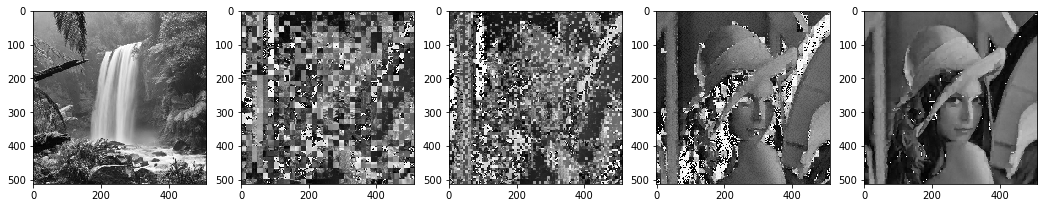

In [9]:
n_iters = [0, 1, 2, 6, 12]
imgs = []
for n in n_iters:
    waterfall = io.imread("test_files/fractal_compr.jpg")
    waterfall_gray_512x512 = np.rint(rgb2gray(waterfall) * 255).astype('uint8')
    image = my_decompress(waterfall_gray_512x512, pair[0], pair[1], n)
    imgs.append(image)
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(0, len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

In [10]:
pair = my_compressor(lenna_gray_512x512, 8, 8, 0.5, 0.9)


0   0   MyBlockTransform(x=12, y=29, shift=0.9, num=1, scale=14.198437499999994)
0   1   MyBlockTransform(x=21, y=30, shift=0.9, num=6, scale=-33.9765625)
0   2   MyBlockTransform(x=4, y=24, shift=0.9, num=6, scale=26.549999999999997)
0   3   MyBlockTransform(x=15, y=27, shift=0.9, num=2, scale=9.442187499999994)
0   4   MyBlockTransform(x=17, y=28, shift=0.9, num=7, scale=22.409374999999997)
0   5   MyBlockTransform(x=19, y=27, shift=0.9, num=3, scale=38.40624999999999)
0   6   MyBlockTransform(x=28, y=21, shift=0.9, num=3, scale=-19.867187500000004)
0   7   MyBlockTransform(x=1, y=3, shift=0.9, num=1, scale=0.9781249999999964)
0   8   MyBlockTransform(x=16, y=0, shift=0.9, num=4, scale=7.249999999999997)
0   9   MyBlockTransform(x=2, y=2, shift=0.9, num=2, scale=-45.0234375)
0   10   MyBlockTransform(x=3, y=8, shift=0.9, num=0, scale=-7.375000000000003)
0   11   MyBlockTransform(x=19, y=27, shift=0.9, num=4, scale=-30.187500000000007)
0   12   MyBlockTransform(x=0, y=9, shift=0.9, nu

1   40   MyBlockTransform(x=5, y=9, shift=0.9, num=7, scale=7.495312499999997)
1   41   MyBlockTransform(x=29, y=21, shift=0.9, num=0, scale=-43.965625)
1   42   MyBlockTransform(x=5, y=6, shift=0.9, num=1, scale=64.7109375)
1   43   MyBlockTransform(x=6, y=6, shift=0.9, num=4, scale=64.6828125)
1   44   MyBlockTransform(x=17, y=28, shift=0.9, num=6, scale=21.315624999999997)
1   45   MyBlockTransform(x=20, y=25, shift=0.9, num=5, scale=19.865624999999998)
1   46   MyBlockTransform(x=2, y=8, shift=0.9, num=6, scale=43.4546875)
1   47   MyBlockTransform(x=13, y=30, shift=0.9, num=2, scale=8.384374999999995)
1   48   MyBlockTransform(x=3, y=25, shift=0.9, num=0, scale=25.631249999999994)
1   49   MyBlockTransform(x=12, y=28, shift=0.9, num=4, scale=4.059374999999991)
1   50   MyBlockTransform(x=19, y=28, shift=0.9, num=1, scale=25.707812499999996)
1   51   MyBlockTransform(x=21, y=14, shift=0.9, num=0, scale=103.7859375)
1   52   MyBlockTransform(x=24, y=29, shift=0.9, num=1, scale=24.81

3   16   MyBlockTransform(x=2, y=17, shift=0.9, num=1, scale=12.284374999999997)
3   17   MyBlockTransform(x=0, y=23, shift=0.9, num=6, scale=-12.125000000000004)
3   18   MyBlockTransform(x=2, y=18, shift=0.9, num=1, scale=14.093749999999996)
3   19   MyBlockTransform(x=13, y=29, shift=0.9, num=3, scale=-19.846875000000008)
3   20   MyBlockTransform(x=31, y=17, shift=0.9, num=1, scale=-1.0781250000000022)
3   21   MyBlockTransform(x=9, y=23, shift=0.9, num=5, scale=-58.06875000000001)
3   22   MyBlockTransform(x=16, y=27, shift=0.9, num=5, scale=-12.603125000000006)
3   23   MyBlockTransform(x=13, y=6, shift=0.9, num=1, scale=39.478125)
3   24   MyBlockTransform(x=19, y=26, shift=0.9, num=0, scale=-6.779687500000003)
3   25   MyBlockTransform(x=10, y=31, shift=0.9, num=4, scale=-17.859375000000004)
3   26   MyBlockTransform(x=21, y=25, shift=0.9, num=7, scale=-15.393750000000004)
3   27   MyBlockTransform(x=13, y=30, shift=0.9, num=6, scale=-21.037500000000005)
3   28   MyBlockTransfo

4   55   MyBlockTransform(x=26, y=29, shift=0.9, num=1, scale=24.378124999999997)
4   56   MyBlockTransform(x=27, y=17, shift=0.9, num=2, scale=-12.148437500000004)
4   57   MyBlockTransform(x=30, y=22, shift=0.9, num=0, scale=-70.13281250000001)
4   58   MyBlockTransform(x=11, y=19, shift=0.9, num=6, scale=-52.55781250000001)
4   59   MyBlockTransform(x=2, y=29, shift=0.9, num=0, scale=9.565624999999997)
4   60   MyBlockTransform(x=16, y=31, shift=0.9, num=6, scale=-81.24062500000001)
4   61   MyBlockTransform(x=30, y=14, shift=0.9, num=7, scale=-62.42968750000001)
4   62   MyBlockTransform(x=1, y=16, shift=0.9, num=0, scale=-65.171875)
4   63   MyBlockTransform(x=1, y=15, shift=0.9, num=3, scale=-67.9859375)
5   0   MyBlockTransform(x=8, y=5, shift=0.9, num=2, scale=73.534375)
5   1   MyBlockTransform(x=29, y=17, shift=0.9, num=3, scale=42.123437499999994)
5   2   MyBlockTransform(x=19, y=30, shift=0.9, num=6, scale=-21.6015625)
5   3   MyBlockTransform(x=0, y=6, shift=0.9, num=5, sc

6   31   MyBlockTransform(x=16, y=25, shift=0.9, num=7, scale=68.740625)
6   32   MyBlockTransform(x=10, y=27, shift=0.9, num=7, scale=67.4984375)
6   33   MyBlockTransform(x=3, y=22, shift=0.9, num=0, scale=-16.448437500000004)
6   34   MyBlockTransform(x=23, y=26, shift=0.9, num=7, scale=-8.657812500000002)
6   35   MyBlockTransform(x=1, y=15, shift=0.9, num=0, scale=8.904687499999998)
6   36   MyBlockTransform(x=5, y=25, shift=0.9, num=1, scale=-3.7265625000000044)
6   37   MyBlockTransform(x=12, y=28, shift=0.9, num=7, scale=-25.143750000000008)
6   38   MyBlockTransform(x=18, y=26, shift=0.9, num=1, scale=-19.609375)
6   39   MyBlockTransform(x=12, y=0, shift=0.9, num=1, scale=20.481249999999996)
6   40   MyBlockTransform(x=4, y=6, shift=0.9, num=3, scale=15.217187499999998)
6   41   MyBlockTransform(x=31, y=21, shift=0.9, num=1, scale=-44.564062500000006)
6   42   MyBlockTransform(x=28, y=21, shift=0.9, num=1, scale=-48.5546875)
6   43   MyBlockTransform(x=2, y=10, shift=0.9, num

8   8   MyBlockTransform(x=27, y=29, shift=0.9, num=6, scale=-11.814062500000002)
8   9   MyBlockTransform(x=21, y=0, shift=0.9, num=7, scale=28.296875)
8   10   MyBlockTransform(x=3, y=22, shift=0.9, num=7, scale=-40.260937500000004)
8   11   MyBlockTransform(x=0, y=24, shift=0.9, num=6, scale=-42.198437500000004)
8   12   MyBlockTransform(x=11, y=20, shift=0.9, num=7, scale=-79.28750000000001)
8   13   MyBlockTransform(x=2, y=9, shift=0.9, num=1, scale=-7.048437500000003)
8   14   MyBlockTransform(x=29, y=15, shift=0.9, num=2, scale=-10.103125000000002)
8   15   MyBlockTransform(x=1, y=0, shift=0.9, num=4, scale=-26.340625000000003)
8   16   MyBlockTransform(x=4, y=24, shift=0.9, num=2, scale=-9.028125000000003)
8   17   MyBlockTransform(x=11, y=31, shift=0.9, num=5, scale=-18.6078125)
8   18   MyBlockTransform(x=31, y=17, shift=0.9, num=3, scale=-7.046875000000003)
8   19   MyBlockTransform(x=16, y=12, shift=0.9, num=7, scale=80.4984375)
8   20   MyBlockTransform(x=0, y=19, shift=0.

9   47   MyBlockTransform(x=30, y=24, shift=0.9, num=0, scale=56.22031249999999)
9   48   MyBlockTransform(x=12, y=29, shift=0.9, num=3, scale=-4.551562500000006)
9   49   MyBlockTransform(x=13, y=31, shift=0.9, num=1, scale=3.693749999999993)
9   50   MyBlockTransform(x=4, y=25, shift=0.9, num=4, scale=13.906249999999996)
9   51   MyBlockTransform(x=7, y=31, shift=0.9, num=3, scale=-3.3921875000000066)
9   52   MyBlockTransform(x=1, y=10, shift=0.9, num=2, scale=26.918749999999996)
9   53   MyBlockTransform(x=4, y=5, shift=0.9, num=4, scale=60.64999999999999)
9   54   MyBlockTransform(x=19, y=29, shift=0.9, num=6, scale=-26.743750000000006)
9   55   MyBlockTransform(x=10, y=27, shift=0.9, num=6, scale=0.5140624999999984)
9   56   MyBlockTransform(x=8, y=30, shift=0.9, num=0, scale=-101.703125)
9   57   MyBlockTransform(x=27, y=25, shift=0.9, num=3, scale=-76.29531250000001)
9   58   MyBlockTransform(x=29, y=11, shift=0.9, num=0, scale=10.310937499999998)
9   59   MyBlockTransform(x=2,

11   21   MyBlockTransform(x=9, y=15, shift=0.9, num=3, scale=-43.167187500000004)
11   22   MyBlockTransform(x=27, y=18, shift=0.9, num=1, scale=-19.598437500000003)
11   23   MyBlockTransform(x=31, y=16, shift=0.9, num=7, scale=1.4499999999999968)
11   24   MyBlockTransform(x=5, y=10, shift=0.9, num=0, scale=31.768749999999997)
11   25   MyBlockTransform(x=18, y=28, shift=0.9, num=5, scale=10.518749999999995)
11   26   MyBlockTransform(x=22, y=16, shift=0.9, num=1, scale=18.362499999999997)
11   27   MyBlockTransform(x=4, y=8, shift=0.9, num=2, scale=36.787499999999994)
11   28   MyBlockTransform(x=0, y=19, shift=0.9, num=6, scale=57.848437499999996)
11   29   MyBlockTransform(x=26, y=28, shift=0.9, num=4, scale=-17.681250000000006)
11   30   MyBlockTransform(x=7, y=12, shift=0.9, num=0, scale=60.25156249999999)
11   31   MyBlockTransform(x=29, y=13, shift=0.9, num=2, scale=109.9765625)
11   32   MyBlockTransform(x=7, y=0, shift=0.9, num=6, scale=132.628125)
11   33   MyBlockTransfor

12   59   MyBlockTransform(x=20, y=30, shift=0.9, num=1, scale=-138.221875)
12   60   MyBlockTransform(x=5, y=0, shift=0.9, num=6, scale=-21.784375000000004)
12   61   MyBlockTransform(x=4, y=23, shift=0.9, num=7, scale=12.481249999999998)
12   62   MyBlockTransform(x=5, y=9, shift=0.9, num=2, scale=50.1203125)
12   63   MyBlockTransform(x=11, y=28, shift=0.9, num=4, scale=16.498437499999994)
13   0   MyBlockTransform(x=27, y=24, shift=0.9, num=2, scale=-42.9203125)
13   1   MyBlockTransform(x=11, y=30, shift=0.9, num=6, scale=-52.62187500000001)
13   2   MyBlockTransform(x=10, y=31, shift=0.9, num=0, scale=-54.95312500000001)
13   3   MyBlockTransform(x=1, y=3, shift=0.9, num=6, scale=-9.287500000000003)
13   4   MyBlockTransform(x=10, y=2, shift=0.9, num=1, scale=6.945312499999995)
13   5   MyBlockTransform(x=23, y=29, shift=0.9, num=3, scale=-32.578125)
13   6   MyBlockTransform(x=28, y=21, shift=0.9, num=6, scale=-27.851562500000004)
13   7   MyBlockTransform(x=1, y=3, shift=0.9, n

14   33   MyBlockTransform(x=4, y=19, shift=0.9, num=3, scale=109.3125)
14   34   MyBlockTransform(x=1, y=19, shift=0.9, num=7, scale=99.8265625)
14   35   MyBlockTransform(x=6, y=16, shift=0.9, num=0, scale=23.249999999999993)
14   36   MyBlockTransform(x=26, y=31, shift=0.9, num=7, scale=121.2640625)
14   37   MyBlockTransform(x=22, y=30, shift=0.9, num=3, scale=17.401562499999997)
14   38   MyBlockTransform(x=23, y=29, shift=0.9, num=7, scale=16.499999999999996)
14   39   MyBlockTransform(x=4, y=26, shift=0.9, num=1, scale=87.20625)
14   40   MyBlockTransform(x=31, y=23, shift=0.9, num=0, scale=28.681249999999995)
14   41   MyBlockTransform(x=29, y=31, shift=0.9, num=3, scale=20.04375)
14   42   MyBlockTransform(x=22, y=2, shift=0.9, num=0, scale=-11.729687500000004)
14   43   MyBlockTransform(x=9, y=31, shift=0.9, num=3, scale=9.292187499999994)
14   44   MyBlockTransform(x=0, y=23, shift=0.9, num=4, scale=15.046874999999996)
14   45   MyBlockTransform(x=1, y=3, shift=0.9, num=1, s

16   8   MyBlockTransform(x=16, y=5, shift=0.9, num=2, scale=-10.203125000000004)
16   9   MyBlockTransform(x=22, y=27, shift=0.9, num=6, scale=-39.515625)
16   10   MyBlockTransform(x=20, y=27, shift=0.9, num=2, scale=-34.8953125)
16   11   MyBlockTransform(x=26, y=16, shift=0.9, num=1, scale=-22.595312500000006)
16   12   MyBlockTransform(x=20, y=30, shift=0.9, num=1, scale=-91.44062500000001)
16   13   MyBlockTransform(x=21, y=26, shift=0.9, num=5, scale=-28.032812500000006)
16   14   MyBlockTransform(x=14, y=20, shift=0.9, num=6, scale=-82.3046875)
16   15   MyBlockTransform(x=10, y=7, shift=0.9, num=0, scale=31.054687499999996)
16   16   MyBlockTransform(x=27, y=13, shift=0.9, num=6, scale=58.34531249999999)
16   17   MyBlockTransform(x=0, y=27, shift=0.9, num=0, scale=-5.084375000000002)
16   18   MyBlockTransform(x=7, y=30, shift=0.9, num=4, scale=-34.8171875)
16   19   MyBlockTransform(x=27, y=31, shift=0.9, num=7, scale=28.346874999999997)
16   20   MyBlockTransform(x=12, y=10

17   46   MyBlockTransform(x=7, y=30, shift=0.9, num=4, scale=66.1828125)
17   47   MyBlockTransform(x=20, y=29, shift=0.9, num=2, scale=25.8609375)
17   48   MyBlockTransform(x=9, y=23, shift=0.9, num=6, scale=21.35312499999999)
17   49   MyBlockTransform(x=11, y=20, shift=0.9, num=1, scale=30.49374999999999)
17   50   MyBlockTransform(x=14, y=20, shift=0.9, num=1, scale=25.179687499999993)
17   51   MyBlockTransform(x=22, y=27, shift=0.9, num=6, scale=96.5)
17   52   MyBlockTransform(x=15, y=22, shift=0.9, num=3, scale=5.298437499999999)
17   53   MyBlockTransform(x=16, y=29, shift=0.9, num=1, scale=-87.853125)
17   54   MyBlockTransform(x=10, y=22, shift=0.9, num=2, scale=-139.73437500000003)
17   55   MyBlockTransform(x=5, y=7, shift=0.9, num=0, scale=-57.032812500000006)
17   56   MyBlockTransform(x=29, y=22, shift=0.9, num=7, scale=-143.134375)
17   57   MyBlockTransform(x=27, y=28, shift=0.9, num=6, scale=-58.975)
17   58   MyBlockTransform(x=3, y=30, shift=0.9, num=4, scale=105

19   21   MyBlockTransform(x=10, y=23, shift=0.9, num=2, scale=-50.46562500000001)
19   22   MyBlockTransform(x=10, y=23, shift=0.9, num=0, scale=-46.95)
19   23   MyBlockTransform(x=12, y=13, shift=0.9, num=2, scale=69.740625)
19   24   MyBlockTransform(x=5, y=10, shift=0.9, num=0, scale=45.190625)
19   25   MyBlockTransform(x=2, y=1, shift=0.9, num=5, scale=0.9843749999999933)
19   26   MyBlockTransform(x=9, y=22, shift=0.9, num=0, scale=-34.0046875)
19   27   MyBlockTransform(x=7, y=30, shift=0.9, num=2, scale=22.198437499999997)
19   28   MyBlockTransform(x=5, y=16, shift=0.9, num=0, scale=-16.990625000000005)
19   29   MyBlockTransform(x=6, y=15, shift=0.9, num=3, scale=-8.412500000000009)
19   30   MyBlockTransform(x=31, y=28, shift=0.9, num=3, scale=96.1234375)
19   31   MyBlockTransform(x=8, y=14, shift=0.9, num=3, scale=10.196874999999995)
19   32   MyBlockTransform(x=15, y=24, shift=0.9, num=7, scale=121.3921875)
19   33   MyBlockTransform(x=14, y=24, shift=0.9, num=4, scale=

20   60   MyBlockTransform(x=10, y=6, shift=0.9, num=3, scale=74.596875)
20   61   MyBlockTransform(x=31, y=14, shift=0.9, num=3, scale=44.262499999999996)
20   62   MyBlockTransform(x=1, y=8, shift=0.9, num=2, scale=45.32499999999999)
20   63   MyBlockTransform(x=31, y=17, shift=0.9, num=1, scale=29.718749999999996)
21   0   MyBlockTransform(x=4, y=25, shift=0.9, num=3, scale=-32.640625)
21   1   MyBlockTransform(x=1, y=22, shift=0.9, num=1, scale=-51.376562500000006)
21   2   MyBlockTransform(x=10, y=22, shift=0.9, num=4, scale=-88.31250000000003)
21   3   MyBlockTransform(x=18, y=20, shift=0.9, num=6, scale=-14.056250000000002)
21   4   MyBlockTransform(x=20, y=14, shift=0.9, num=1, scale=55.660937499999996)
21   5   MyBlockTransform(x=20, y=30, shift=0.9, num=5, scale=-17.753124999999997)
21   6   MyBlockTransform(x=14, y=27, shift=0.9, num=2, scale=26.514062499999998)
21   7   MyBlockTransform(x=6, y=3, shift=0.9, num=0, scale=3.9562499999999954)
21   8   MyBlockTransform(x=4, y=2

22   35   MyBlockTransform(x=25, y=11, shift=0.9, num=5, scale=5.154687499999998)
22   36   MyBlockTransform(x=25, y=29, shift=0.9, num=6, scale=-11.767187500000006)
22   37   MyBlockTransform(x=31, y=31, shift=0.9, num=0, scale=124.19843749999998)
22   38   MyBlockTransform(x=28, y=31, shift=0.9, num=2, scale=117.9625)
22   39   MyBlockTransform(x=18, y=27, shift=0.9, num=0, scale=64.85624999999999)
22   40   MyBlockTransform(x=13, y=29, shift=0.9, num=0, scale=53.69999999999999)
22   41   MyBlockTransform(x=19, y=31, shift=0.9, num=4, scale=7.78125)
22   42   MyBlockTransform(x=18, y=26, shift=0.9, num=6, scale=64.28125)
22   43   MyBlockTransform(x=31, y=16, shift=0.9, num=5, scale=80.559375)
22   44   MyBlockTransform(x=21, y=27, shift=0.9, num=3, scale=80.5171875)
22   45   MyBlockTransform(x=23, y=31, shift=0.9, num=0, scale=23.459374999999994)
22   46   MyBlockTransform(x=0, y=26, shift=0.9, num=7, scale=8.176562499999996)
22   47   MyBlockTransform(x=26, y=29, shift=0.9, num=4,

24   10   MyBlockTransform(x=1, y=5, shift=0.9, num=7, scale=1.0218749999999965)
24   11   MyBlockTransform(x=0, y=10, shift=0.9, num=7, scale=-22.781250000000004)
24   12   MyBlockTransform(x=8, y=0, shift=0.9, num=1, scale=8.643749999999999)
24   13   MyBlockTransform(x=3, y=25, shift=0.9, num=6, scale=-30.993750000000006)
24   14   MyBlockTransform(x=29, y=21, shift=0.9, num=6, scale=-90.2625)
24   15   MyBlockTransform(x=24, y=19, shift=0.9, num=4, scale=23.517187499999995)
24   16   MyBlockTransform(x=9, y=19, shift=0.9, num=5, scale=31.128124999999994)
24   17   MyBlockTransform(x=9, y=24, shift=0.9, num=1, scale=-20.768750000000004)
24   18   MyBlockTransform(x=26, y=9, shift=0.9, num=3, scale=26.5796875)
24   19   MyBlockTransform(x=20, y=17, shift=0.9, num=3, scale=-8.553125000000005)
24   20   MyBlockTransform(x=13, y=19, shift=0.9, num=6, scale=-49.915625000000006)
24   21   MyBlockTransform(x=6, y=27, shift=0.9, num=0, scale=77.91093749999999)
24   22   MyBlockTransform(x=2

25   49   MyBlockTransform(x=1, y=23, shift=0.9, num=3, scale=-90.6015625)
25   50   MyBlockTransform(x=23, y=30, shift=0.9, num=4, scale=-142.16875)
25   51   MyBlockTransform(x=0, y=14, shift=0.9, num=4, scale=-71.26875000000001)
25   52   MyBlockTransform(x=2, y=0, shift=0.9, num=0, scale=-94.0640625)
25   53   MyBlockTransform(x=0, y=25, shift=0.9, num=1, scale=-70.37812500000001)
25   54   MyBlockTransform(x=29, y=30, shift=0.9, num=0, scale=57.0796875)
25   55   MyBlockTransform(x=31, y=16, shift=0.9, num=7, scale=41.403124999999996)
25   56   MyBlockTransform(x=11, y=31, shift=0.9, num=1, scale=24.7984375)
25   57   MyBlockTransform(x=13, y=28, shift=0.9, num=3, scale=15.548437499999993)
25   58   MyBlockTransform(x=4, y=25, shift=0.9, num=7, scale=36.10937499999999)
25   59   MyBlockTransform(x=27, y=16, shift=0.9, num=5, scale=40.540625)
25   60   MyBlockTransform(x=9, y=31, shift=0.9, num=5, scale=18.120312499999997)
25   61   MyBlockTransform(x=15, y=5, shift=0.9, num=4, sca

27   24   MyBlockTransform(x=0, y=29, shift=0.9, num=6, scale=-64.521875)
27   25   MyBlockTransform(x=15, y=26, shift=0.9, num=1, scale=-72.1265625)
27   26   MyBlockTransform(x=15, y=26, shift=0.9, num=3, scale=-72.4234375)
27   27   MyBlockTransform(x=19, y=28, shift=0.9, num=1, scale=-65.30781250000001)
27   28   MyBlockTransform(x=16, y=10, shift=0.9, num=1, scale=20.268749999999997)
27   29   MyBlockTransform(x=31, y=26, shift=0.9, num=7, scale=-54.57343750000001)
27   30   MyBlockTransform(x=30, y=27, shift=0.9, num=6, scale=-25.645312500000003)
27   31   MyBlockTransform(x=29, y=28, shift=0.9, num=6, scale=45.764062499999994)
27   32   MyBlockTransform(x=10, y=23, shift=0.9, num=2, scale=-38.903125)
27   33   MyBlockTransform(x=10, y=21, shift=0.9, num=2, scale=4.903124999999994)
27   34   MyBlockTransform(x=1, y=21, shift=0.9, num=3, scale=46.7265625)
27   35   MyBlockTransform(x=9, y=23, shift=0.9, num=2, scale=-18.77187500000001)
27   36   MyBlockTransform(x=22, y=16, shift=

28   63   MyBlockTransform(x=23, y=26, shift=0.9, num=0, scale=18.498437499999998)
29   0   MyBlockTransform(x=1, y=9, shift=0.9, num=0, scale=-14.300000000000002)
29   1   MyBlockTransform(x=27, y=24, shift=0.9, num=4, scale=-33.3109375)
29   2   MyBlockTransform(x=27, y=25, shift=0.9, num=0, scale=-33.7796875)
29   3   MyBlockTransform(x=1, y=3, shift=0.9, num=6, scale=-17.803125000000005)
29   4   MyBlockTransform(x=22, y=2, shift=0.9, num=1, scale=7.379687499999995)
29   5   MyBlockTransform(x=13, y=29, shift=0.9, num=0, scale=28.403124999999992)
29   6   MyBlockTransform(x=13, y=31, shift=0.9, num=0, scale=32.834374999999994)
29   7   MyBlockTransform(x=5, y=3, shift=0.9, num=0, scale=11.265624999999996)
29   8   MyBlockTransform(x=3, y=20, shift=0.9, num=3, scale=-19.050000000000004)
29   9   MyBlockTransform(x=30, y=22, shift=0.9, num=0, scale=-100.77343750000001)
29   10   MyBlockTransform(x=0, y=14, shift=0.9, num=2, scale=-18.534375)
29   11   MyBlockTransform(x=3, y=8, shift

30   38   MyBlockTransform(x=31, y=22, shift=0.9, num=0, scale=6.859374999999996)
30   39   MyBlockTransform(x=7, y=6, shift=0.9, num=5, scale=105.53437500000001)
30   40   MyBlockTransform(x=23, y=26, shift=0.9, num=7, scale=68.3890625)
30   41   MyBlockTransform(x=9, y=29, shift=0.9, num=1, scale=67.4484375)
30   42   MyBlockTransform(x=4, y=0, shift=0.9, num=0, scale=60.590624999999996)
30   43   MyBlockTransform(x=28, y=28, shift=0.9, num=0, scale=-31.4765625)
30   44   MyBlockTransform(x=16, y=0, shift=0.9, num=4, scale=-44.65625000000001)
30   45   MyBlockTransform(x=27, y=0, shift=0.9, num=0, scale=31.878124999999994)
30   46   MyBlockTransform(x=18, y=24, shift=0.9, num=3, scale=16.874999999999996)
30   47   MyBlockTransform(x=0, y=21, shift=0.9, num=1, scale=-80.3203125)
30   48   MyBlockTransform(x=22, y=30, shift=0.9, num=4, scale=-135.4109375)
30   49   MyBlockTransform(x=2, y=11, shift=0.9, num=7, scale=-64.7796875)
30   50   MyBlockTransform(x=27, y=25, shift=0.9, num=1, 

32   12   MyBlockTransform(x=14, y=27, shift=0.9, num=1, scale=-51.845312500000006)
32   13   MyBlockTransform(x=24, y=10, shift=0.9, num=5, scale=56.7421875)
32   14   MyBlockTransform(x=17, y=17, shift=0.9, num=5, scale=6.526562499999995)
32   15   MyBlockTransform(x=11, y=21, shift=0.9, num=0, scale=-31.962500000000006)
32   16   MyBlockTransform(x=5, y=23, shift=0.9, num=5, scale=42.32968749999999)
32   17   MyBlockTransform(x=10, y=27, shift=0.9, num=6, scale=-1.9390625000000015)
32   18   MyBlockTransform(x=12, y=14, shift=0.9, num=4, scale=16.178124999999994)
32   19   MyBlockTransform(x=28, y=5, shift=0.9, num=4, scale=42.121875)
32   20   MyBlockTransform(x=14, y=26, shift=0.9, num=0, scale=-36.126562500000006)
32   21   MyBlockTransform(x=30, y=6, shift=0.9, num=1, scale=1.4749999999999988)
32   22   MyBlockTransform(x=18, y=1, shift=0.9, num=0, scale=-0.5546875000000014)
32   23   MyBlockTransform(x=6, y=25, shift=0.9, num=2, scale=-87.421875)
32   24   MyBlockTransform(x=29

33   50   MyBlockTransform(x=19, y=24, shift=0.9, num=0, scale=7.484374999999997)
33   51   MyBlockTransform(x=2, y=20, shift=0.9, num=1, scale=42.310937499999994)
33   52   MyBlockTransform(x=22, y=25, shift=0.9, num=1, scale=20.185937499999994)
33   53   MyBlockTransform(x=27, y=25, shift=0.9, num=1, scale=31.8765625)
33   54   MyBlockTransform(x=0, y=9, shift=0.9, num=5, scale=37.85937499999999)
33   55   MyBlockTransform(x=2, y=7, shift=0.9, num=2, scale=46.474999999999994)
33   56   MyBlockTransform(x=4, y=8, shift=0.9, num=3, scale=45.318749999999994)
33   57   MyBlockTransform(x=12, y=29, shift=0.9, num=1, scale=8.214062499999994)
33   58   MyBlockTransform(x=15, y=27, shift=0.9, num=0, scale=8.645312499999994)
33   59   MyBlockTransform(x=22, y=26, shift=0.9, num=1, scale=14.829687499999995)
33   60   MyBlockTransform(x=10, y=22, shift=0.9, num=6, scale=-40.32812500000001)
33   61   MyBlockTransform(x=14, y=27, shift=0.9, num=1, scale=-2.642187500000004)
33   62   MyBlockTransf

35   25   MyBlockTransform(x=9, y=28, shift=0.9, num=0, scale=-12.718750000000002)
35   26   MyBlockTransform(x=20, y=24, shift=0.9, num=0, scale=48.6046875)
35   27   MyBlockTransform(x=6, y=19, shift=0.9, num=7, scale=2.529687499999996)
35   28   MyBlockTransform(x=6, y=20, shift=0.9, num=1, scale=15.889062499999998)
35   29   MyBlockTransform(x=29, y=21, shift=0.9, num=1, scale=-52.371875)
35   30   MyBlockTransform(x=19, y=26, shift=0.9, num=2, scale=13.032812499999997)
35   31   MyBlockTransform(x=29, y=21, shift=0.9, num=4, scale=-26.090625000000003)
35   32   MyBlockTransform(x=11, y=1, shift=0.9, num=4, scale=50.467187499999994)
35   33   MyBlockTransform(x=19, y=17, shift=0.9, num=2, scale=19.301562499999996)
35   34   MyBlockTransform(x=20, y=17, shift=0.9, num=5, scale=28.228125)
35   35   MyBlockTransform(x=13, y=27, shift=0.9, num=6, scale=13.889062499999994)
35   36   MyBlockTransform(x=15, y=6, shift=0.9, num=7, scale=40.63281249999999)
35   37   MyBlockTransform(x=0, y=

37   0   MyBlockTransform(x=27, y=17, shift=0.9, num=5, scale=-47.36718750000001)
37   1   MyBlockTransform(x=16, y=5, shift=0.9, num=1, scale=-14.953125000000002)
37   2   MyBlockTransform(x=27, y=18, shift=0.9, num=3, scale=-72.41093750000002)
37   3   MyBlockTransform(x=21, y=1, shift=0.9, num=0, scale=4.531249999999997)
37   4   MyBlockTransform(x=18, y=20, shift=0.9, num=3, scale=20.537499999999994)
37   5   MyBlockTransform(x=19, y=26, shift=0.9, num=7, scale=39.26718749999999)
37   6   MyBlockTransform(x=12, y=0, shift=0.9, num=1, scale=84.840625)
37   7   MyBlockTransform(x=1, y=3, shift=0.9, num=0, scale=15.306249999999997)
37   8   MyBlockTransform(x=4, y=20, shift=0.9, num=3, scale=-14.248437500000001)
37   9   MyBlockTransform(x=0, y=2, shift=0.9, num=0, scale=-53.485937500000006)
37   10   MyBlockTransform(x=29, y=19, shift=0.9, num=0, scale=-29.437500000000004)
37   11   MyBlockTransform(x=7, y=12, shift=0.9, num=4, scale=-10.232812500000005)
37   12   MyBlockTransform(x=

38   38   MyBlockTransform(x=5, y=1, shift=0.9, num=1, scale=57.140625)
38   39   MyBlockTransform(x=30, y=30, shift=0.9, num=3, scale=124.68906249999999)
38   40   MyBlockTransform(x=14, y=27, shift=0.9, num=7, scale=13.842187499999998)
38   41   MyBlockTransform(x=0, y=19, shift=0.9, num=0, scale=37.910937499999996)
38   42   MyBlockTransform(x=20, y=17, shift=0.9, num=1, scale=-12.381250000000005)
38   43   MyBlockTransform(x=12, y=1, shift=0.9, num=3, scale=-41.2578125)
38   44   MyBlockTransform(x=2, y=21, shift=0.9, num=1, scale=-72.6875)
38   45   MyBlockTransform(x=13, y=1, shift=0.9, num=3, scale=-42.40468750000001)
38   46   MyBlockTransform(x=24, y=28, shift=0.9, num=1, scale=-41.29375)
38   47   MyBlockTransform(x=28, y=0, shift=0.9, num=6, scale=1.6718749999999978)
38   48   MyBlockTransform(x=19, y=28, shift=0.9, num=0, scale=-76.91718750000001)
38   49   MyBlockTransform(x=25, y=28, shift=0.9, num=0, scale=-56.35468750000001)
38   50   MyBlockTransform(x=7, y=2, shift=0.

40   12   MyBlockTransform(x=31, y=1, shift=0.9, num=1, scale=-67.24531250000001)
40   13   MyBlockTransform(x=15, y=25, shift=0.9, num=0, scale=7.909374999999998)
40   14   MyBlockTransform(x=14, y=25, shift=0.9, num=6, scale=25.809375000000003)
40   15   MyBlockTransform(x=14, y=23, shift=0.9, num=6, scale=54.498437499999994)
40   16   MyBlockTransform(x=28, y=14, shift=0.9, num=1, scale=26.914062499999993)
40   17   MyBlockTransform(x=15, y=12, shift=0.9, num=0, scale=2.3718749999999993)
40   18   MyBlockTransform(x=24, y=6, shift=0.9, num=0, scale=5.582812499999998)
40   19   MyBlockTransform(x=29, y=29, shift=0.9, num=5, scale=-33.759375000000006)
40   20   MyBlockTransform(x=29, y=9, shift=0.9, num=3, scale=-9.140625000000002)
40   21   MyBlockTransform(x=3, y=17, shift=0.9, num=1, scale=-64.40312499999999)
40   22   MyBlockTransform(x=14, y=22, shift=0.9, num=1, scale=-4.115625000000003)
40   23   MyBlockTransform(x=30, y=30, shift=0.9, num=5, scale=87.6265625)
40   24   MyBlock

41   50   MyBlockTransform(x=30, y=18, shift=0.9, num=2, scale=31.814062499999995)
41   51   MyBlockTransform(x=2, y=18, shift=0.9, num=4, scale=40.140625)
41   52   MyBlockTransform(x=2, y=18, shift=0.9, num=6, scale=38.09375)
41   53   MyBlockTransform(x=11, y=30, shift=0.9, num=7, scale=7.081249999999994)
41   54   MyBlockTransform(x=30, y=15, shift=0.9, num=4, scale=25.684374999999996)
41   55   MyBlockTransform(x=12, y=28, shift=0.9, num=4, scale=-4.518750000000009)
41   56   MyBlockTransform(x=2, y=20, shift=0.9, num=1, scale=37.185937499999994)
41   57   MyBlockTransform(x=24, y=2, shift=0.9, num=1, scale=46.24374999999999)
41   58   MyBlockTransform(x=30, y=19, shift=0.9, num=1, scale=72.3515625)
41   59   MyBlockTransform(x=1, y=24, shift=0.9, num=3, scale=73.796875)
41   60   MyBlockTransform(x=13, y=29, shift=0.9, num=0, scale=63.76249999999999)
41   61   MyBlockTransform(x=13, y=30, shift=0.9, num=6, scale=68.02499999999999)
41   62   MyBlockTransform(x=5, y=25, shift=0.9, 

43   25   MyBlockTransform(x=25, y=18, shift=0.9, num=0, scale=-87.0078125)
43   26   MyBlockTransform(x=4, y=20, shift=0.9, num=6, scale=-46.4359375)
43   27   MyBlockTransform(x=26, y=12, shift=0.9, num=0, scale=39.940625)
43   28   MyBlockTransform(x=19, y=17, shift=0.9, num=3, scale=-32.917187500000004)
43   29   MyBlockTransform(x=4, y=16, shift=0.9, num=0, scale=-54.81093750000001)
43   30   MyBlockTransform(x=27, y=17, shift=0.9, num=0, scale=4.7734374999999964)
43   31   MyBlockTransform(x=5, y=6, shift=0.9, num=1, scale=43.3359375)
43   32   MyBlockTransform(x=13, y=6, shift=0.9, num=4, scale=49.72812499999999)
43   33   MyBlockTransform(x=28, y=27, shift=0.9, num=5, scale=-60.620312500000004)
43   34   MyBlockTransform(x=7, y=22, shift=0.9, num=7, scale=-2.2984375000000026)
43   35   MyBlockTransform(x=1, y=3, shift=0.9, num=7, scale=-1.9281250000000036)
43   36   MyBlockTransform(x=21, y=28, shift=0.9, num=5, scale=-32.146875)
43   37   MyBlockTransform(x=22, y=1, shift=0.9,

45   1   MyBlockTransform(x=14, y=20, shift=0.9, num=5, scale=-138.2265625)
45   2   MyBlockTransform(x=29, y=31, shift=0.9, num=6, scale=2.965624999999998)
45   3   MyBlockTransform(x=5, y=1, shift=0.9, num=0, scale=16.625)
45   4   MyBlockTransform(x=29, y=21, shift=0.9, num=0, scale=-22.809375000000003)
45   5   MyBlockTransform(x=14, y=20, shift=0.9, num=0, scale=-11.664062500000007)
45   6   MyBlockTransform(x=3, y=21, shift=0.9, num=3, scale=52.37656249999999)
45   7   MyBlockTransform(x=28, y=13, shift=0.9, num=6, scale=64.390625)
45   8   MyBlockTransform(x=13, y=1, shift=0.9, num=3, scale=-17.1078125)
45   9   MyBlockTransform(x=17, y=6, shift=0.9, num=4, scale=12.729687499999995)
45   10   MyBlockTransform(x=0, y=25, shift=0.9, num=3, scale=-89.01875)
45   11   MyBlockTransform(x=26, y=6, shift=0.9, num=6, scale=24.6390625)
45   12   MyBlockTransform(x=27, y=26, shift=0.9, num=0, scale=-68.3734375)
45   13   MyBlockTransform(x=10, y=9, shift=0.9, num=1, scale=-31.2890625)
45 

46   41   MyBlockTransform(x=13, y=7, shift=0.9, num=3, scale=-40.307812500000004)
46   42   MyBlockTransform(x=7, y=28, shift=0.9, num=6, scale=9.393749999999997)
46   43   MyBlockTransform(x=27, y=26, shift=0.9, num=0, scale=-64.2171875)
46   44   MyBlockTransform(x=16, y=4, shift=0.9, num=0, scale=4.334374999999998)
46   45   MyBlockTransform(x=21, y=21, shift=0.9, num=0, scale=23.253124999999997)
46   46   MyBlockTransform(x=24, y=22, shift=0.9, num=6, scale=-15.425)
46   47   MyBlockTransform(x=23, y=11, shift=0.9, num=1, scale=111.3890625)
46   48   MyBlockTransform(x=18, y=18, shift=0.9, num=6, scale=31.959374999999994)
46   49   MyBlockTransform(x=4, y=25, shift=0.9, num=0, scale=31.031249999999993)
46   50   MyBlockTransform(x=0, y=28, shift=0.9, num=5, scale=47.390625)
46   51   MyBlockTransform(x=0, y=17, shift=0.9, num=2, scale=39.731249999999996)
46   52   MyBlockTransform(x=16, y=29, shift=0.9, num=5, scale=15.834374999999996)
46   53   MyBlockTransform(x=3, y=18, shift=0

48   16   MyBlockTransform(x=31, y=1, shift=0.9, num=6, scale=-66.87031250000001)
48   17   MyBlockTransform(x=24, y=8, shift=0.9, num=0, scale=18.2421875)
48   18   MyBlockTransform(x=10, y=23, shift=0.9, num=3, scale=-45.5125)
48   19   MyBlockTransform(x=17, y=6, shift=0.9, num=3, scale=16.339062499999997)
48   20   MyBlockTransform(x=30, y=27, shift=0.9, num=1, scale=-15.817187500000003)
48   21   MyBlockTransform(x=30, y=17, shift=0.9, num=6, scale=-78.43125)
48   22   MyBlockTransform(x=23, y=18, shift=0.9, num=4, scale=-80.13906250000001)
48   23   MyBlockTransform(x=18, y=18, shift=0.9, num=3, scale=-68.05625)
48   24   MyBlockTransform(x=20, y=27, shift=0.9, num=7, scale=-83.02031249999999)
48   25   MyBlockTransform(x=22, y=31, shift=0.9, num=5, scale=-143.415625)
48   26   MyBlockTransform(x=3, y=18, shift=0.9, num=7, scale=-61.0234375)
48   27   MyBlockTransform(x=3, y=18, shift=0.9, num=3, scale=-52.7734375)
48   28   MyBlockTransform(x=20, y=16, shift=0.9, num=3, scale=-7

49   55   MyBlockTransform(x=19, y=14, shift=0.9, num=5, scale=4.3828124999999964)
49   56   MyBlockTransform(x=26, y=2, shift=0.9, num=0, scale=57.109375)
49   57   MyBlockTransform(x=12, y=6, shift=0.9, num=2, scale=124.828125)
49   58   MyBlockTransform(x=10, y=31, shift=0.9, num=4, scale=71.34375)
49   59   MyBlockTransform(x=1, y=21, shift=0.9, num=3, scale=66.9609375)
49   60   MyBlockTransform(x=2, y=27, shift=0.9, num=7, scale=-14.846875000000002)
49   61   MyBlockTransform(x=5, y=27, shift=0.9, num=0, scale=7.687499999999998)
49   62   MyBlockTransform(x=25, y=26, shift=0.9, num=3, scale=-44.306250000000006)
49   63   MyBlockTransform(x=18, y=28, shift=0.9, num=2, scale=-49.95)
50   0   MyBlockTransform(x=22, y=16, shift=0.9, num=2, scale=12.299999999999997)
50   1   MyBlockTransform(x=31, y=30, shift=0.9, num=5, scale=30.164062499999996)
50   2   MyBlockTransform(x=23, y=17, shift=0.9, num=7, scale=-63.575)
50   3   MyBlockTransform(x=6, y=1, shift=0.9, num=1, scale=-30.01406

51   30   MyBlockTransform(x=19, y=2, shift=0.9, num=0, scale=-42.21093750000001)
51   31   MyBlockTransform(x=10, y=21, shift=0.9, num=6, scale=-62.503125000000004)
51   32   MyBlockTransform(x=22, y=15, shift=0.9, num=1, scale=20.025)
51   33   MyBlockTransform(x=21, y=31, shift=0.9, num=5, scale=-59.771874999999994)
51   34   MyBlockTransform(x=2, y=24, shift=0.9, num=1, scale=-1.1140625000000033)
51   35   MyBlockTransform(x=18, y=31, shift=0.9, num=4, scale=-39.495312500000004)
51   36   MyBlockTransform(x=22, y=27, shift=0.9, num=6, scale=31.281249999999996)
51   37   MyBlockTransform(x=3, y=24, shift=0.9, num=7, scale=37.97812499999999)
51   38   MyBlockTransform(x=29, y=22, shift=0.9, num=2, scale=-14.978125000000006)
51   39   MyBlockTransform(x=14, y=27, shift=0.9, num=6, scale=48.248437499999994)
51   40   MyBlockTransform(x=6, y=6, shift=0.9, num=0, scale=109.37031250000001)
51   41   MyBlockTransform(x=19, y=27, shift=0.9, num=6, scale=79.375)
51   42   MyBlockTransform(x=

53   5   MyBlockTransform(x=1, y=22, shift=0.9, num=4, scale=33.123437499999994)
53   6   MyBlockTransform(x=9, y=30, shift=0.9, num=5, scale=34.59375)
53   7   MyBlockTransform(x=1, y=3, shift=0.9, num=1, scale=26.165624999999995)
53   8   MyBlockTransform(x=22, y=28, shift=0.9, num=3, scale=-65.29375)
53   9   MyBlockTransform(x=12, y=18, shift=0.9, num=6, scale=-121.9859375)
53   10   MyBlockTransform(x=3, y=0, shift=0.9, num=6, scale=-95.2046875)
53   11   MyBlockTransform(x=21, y=29, shift=0.9, num=5, scale=-145.7203125)
53   12   MyBlockTransform(x=26, y=29, shift=0.9, num=6, scale=-36.29375)
53   13   MyBlockTransform(x=28, y=0, shift=0.9, num=3, scale=10.171874999999996)
53   14   MyBlockTransform(x=1, y=20, shift=0.9, num=3, scale=-49.4296875)
53   15   MyBlockTransform(x=31, y=31, shift=0.9, num=5, scale=2.151562499999998)
53   16   MyBlockTransform(x=30, y=12, shift=0.9, num=5, scale=-3.723437500000002)
53   17   MyBlockTransform(x=5, y=16, shift=0.9, num=5, scale=-93.990625

54   44   MyBlockTransform(x=1, y=22, shift=0.9, num=7, scale=80.2171875)
54   45   MyBlockTransform(x=29, y=23, shift=0.9, num=0, scale=-33.189062500000006)
54   46   MyBlockTransform(x=23, y=28, shift=0.9, num=0, scale=-65.22968750000001)
54   47   MyBlockTransform(x=3, y=21, shift=0.9, num=0, scale=20.7671875)
54   48   MyBlockTransform(x=5, y=25, shift=0.9, num=5, scale=18.570312499999996)
54   49   MyBlockTransform(x=7, y=31, shift=0.9, num=0, scale=0.15468749999999343)
54   50   MyBlockTransform(x=19, y=27, shift=0.9, num=0, scale=8.343749999999998)
54   51   MyBlockTransform(x=0, y=5, shift=0.9, num=5, scale=43.0390625)
54   52   MyBlockTransform(x=12, y=29, shift=0.9, num=7, scale=-18.739062500000003)
54   53   MyBlockTransform(x=18, y=24, shift=0.9, num=0, scale=78.609375)
54   54   MyBlockTransform(x=11, y=28, shift=0.9, num=0, scale=72.2796875)
54   55   MyBlockTransform(x=27, y=17, shift=0.9, num=1, scale=92.4453125)
54   56   MyBlockTransform(x=30, y=22, shift=0.9, num=3, 

56   19   MyBlockTransform(x=18, y=25, shift=0.9, num=0, scale=-20.960937500000004)
56   20   MyBlockTransform(x=31, y=29, shift=0.9, num=1, scale=17.685937499999998)
56   21   MyBlockTransform(x=15, y=16, shift=0.9, num=5, scale=-43.142187500000006)
56   22   MyBlockTransform(x=25, y=11, shift=0.9, num=0, scale=-0.07968750000000102)
56   23   MyBlockTransform(x=25, y=13, shift=0.9, num=1, scale=4.587499999999999)
56   24   MyBlockTransform(x=1, y=25, shift=0.9, num=2, scale=-80.05156249999999)
56   25   MyBlockTransform(x=29, y=22, shift=0.9, num=3, scale=-145.21250000000003)
56   26   MyBlockTransform(x=25, y=26, shift=0.9, num=5, scale=-35.337500000000006)
56   27   MyBlockTransform(x=21, y=14, shift=0.9, num=1, scale=7.2546874999999975)
56   28   MyBlockTransform(x=19, y=29, shift=0.9, num=6, scale=-55.837500000000006)
56   29   MyBlockTransform(x=24, y=25, shift=0.9, num=7, scale=-32.1765625)
56   30   MyBlockTransform(x=15, y=19, shift=0.9, num=1, scale=-45.7234375)
56   31   MyB

57   58   MyBlockTransform(x=5, y=17, shift=0.9, num=2, scale=-101.51250000000002)
57   59   MyBlockTransform(x=27, y=30, shift=0.9, num=0, scale=-8.934375000000003)
57   60   MyBlockTransform(x=2, y=1, shift=0.9, num=2, scale=-51.093750000000014)
57   61   MyBlockTransform(x=28, y=18, shift=0.9, num=3, scale=-39.3875)
57   62   MyBlockTransform(x=23, y=30, shift=0.9, num=2, scale=-101.2625)
57   63   MyBlockTransform(x=25, y=26, shift=0.9, num=7, scale=-26.243750000000006)
58   0   MyBlockTransform(x=9, y=23, shift=0.9, num=7, scale=-151.49062500000002)
58   1   MyBlockTransform(x=27, y=0, shift=0.9, num=0, scale=17.409374999999997)
58   2   MyBlockTransform(x=5, y=21, shift=0.9, num=6, scale=42.910937499999996)
58   3   MyBlockTransform(x=15, y=25, shift=0.9, num=3, scale=17.784374999999997)
58   4   MyBlockTransform(x=30, y=2, shift=0.9, num=0, scale=-5.617187500000004)
58   5   MyBlockTransform(x=27, y=16, shift=0.9, num=3, scale=52.43124999999999)
58   6   MyBlockTransform(x=31, y

59   33   MyBlockTransform(x=4, y=25, shift=0.9, num=0, scale=13.265624999999996)
59   34   MyBlockTransform(x=31, y=15, shift=0.9, num=4, scale=18.984375)
59   35   MyBlockTransform(x=4, y=8, shift=0.9, num=4, scale=26.209374999999998)
59   36   MyBlockTransform(x=0, y=11, shift=0.9, num=6, scale=18.492187499999996)
59   37   MyBlockTransform(x=3, y=7, shift=0.9, num=0, scale=32.756249999999994)
59   38   MyBlockTransform(x=1, y=1, shift=0.9, num=5, scale=3.6671874999999945)
59   39   MyBlockTransform(x=14, y=5, shift=0.9, num=1, scale=64.703125)
59   40   MyBlockTransform(x=6, y=6, shift=0.9, num=0, scale=71.57343749999998)
59   41   MyBlockTransform(x=26, y=21, shift=0.9, num=0, scale=-17.92812500000001)
59   42   MyBlockTransform(x=0, y=19, shift=0.9, num=6, scale=89.16093749999999)
59   43   MyBlockTransform(x=30, y=19, shift=0.9, num=0, scale=76.1171875)
59   44   MyBlockTransform(x=13, y=29, shift=0.9, num=0, scale=65.82499999999999)
59   45   MyBlockTransform(x=15, y=30, shift=

61   8   MyBlockTransform(x=22, y=14, shift=0.9, num=3, scale=-19.09375)
61   9   MyBlockTransform(x=16, y=27, shift=0.9, num=7, scale=-92.9)
61   10   MyBlockTransform(x=26, y=21, shift=0.9, num=1, scale=-142.85000000000002)
61   11   MyBlockTransform(x=17, y=29, shift=0.9, num=5, scale=-77.609375)
61   12   MyBlockTransform(x=30, y=4, shift=0.9, num=1, scale=0.5140624999999988)
61   13   MyBlockTransform(x=17, y=22, shift=0.9, num=0, scale=12.401562499999999)
61   14   MyBlockTransform(x=30, y=6, shift=0.9, num=1, scale=10.037499999999998)
61   15   MyBlockTransform(x=24, y=15, shift=0.9, num=7, scale=-2.7406250000000023)
61   16   MyBlockTransform(x=19, y=4, shift=0.9, num=0, scale=-22.6234375)
61   17   MyBlockTransform(x=24, y=31, shift=0.9, num=5, scale=2.5578124999999985)
61   18   MyBlockTransform(x=21, y=4, shift=0.9, num=3, scale=-9.171875000000002)
61   19   MyBlockTransform(x=24, y=26, shift=0.9, num=7, scale=-7.165625000000002)
61   20   MyBlockTransform(x=5, y=0, shift=0.

62   47   MyBlockTransform(x=30, y=23, shift=0.9, num=0, scale=1.6749999999999936)
62   48   MyBlockTransform(x=27, y=19, shift=0.9, num=0, scale=-63.68750000000001)
62   49   MyBlockTransform(x=8, y=19, shift=0.9, num=2, scale=-81.09687500000001)
62   50   MyBlockTransform(x=15, y=30, shift=0.9, num=5, scale=-20.785937500000003)
62   51   MyBlockTransform(x=14, y=5, shift=0.9, num=3, scale=26.015624999999996)
62   52   MyBlockTransform(x=30, y=22, shift=0.9, num=6, scale=-81.1953125)
62   53   MyBlockTransform(x=8, y=25, shift=0.9, num=7, scale=-96.5515625)
62   54   MyBlockTransform(x=24, y=17, shift=0.9, num=4, scale=-25.684375000000003)
62   55   MyBlockTransform(x=15, y=31, shift=0.9, num=5, scale=-42.267187500000006)
62   56   MyBlockTransform(x=26, y=30, shift=0.9, num=0, scale=1.2468749999999973)
62   57   MyBlockTransform(x=2, y=20, shift=0.9, num=5, scale=-25.689062500000006)
62   58   MyBlockTransform(x=19, y=0, shift=0.9, num=5, scale=4.146874999999998)
62   59   MyBlockTra

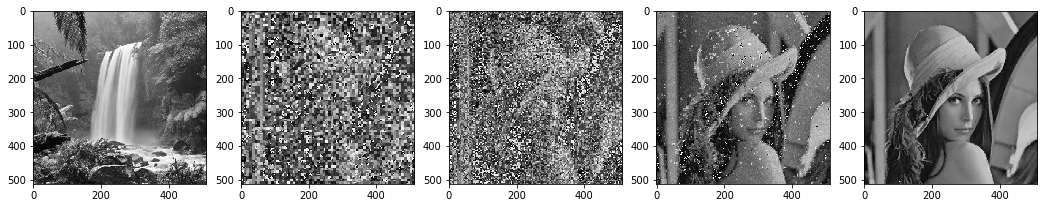

In [11]:
n_iters = [0, 1, 2, 6, 12]
imgs = []
for n in n_iters:
    waterfall = io.imread("test_files/fractal_compr.jpg")
    waterfall_gray_512x512 = np.rint(rgb2gray(waterfall) * 255).astype('uint8')
    image = my_decompress(waterfall_gray_512x512, pair[0], pair[1], n)
    imgs.append(image)
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(0, len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()
